<h1>Image Dehazing</h1>
<h3>This is a basic project about image dehazing using tensorflow keras</h3>
In this course we will be exploring the use of tensorflow keras for image dehazing.

Image dehazing is a digital image processing technique aimed at improving the visibility and clarity of images that have been degraded by atmospheric haze or fog. By removing the effects of haze, dehazing algorithms enhance the visual quality of images, making objects and details more distinguishable and restoring natural colors and contrast. 

This process is particularly useful in various applications such as surveillance, remote sensing, and outdoor photography, where visibility is often compromised by adverse weather conditions or environmental factors.

Image dehazing plays a crucial role in enhancing the performance of models tasked with more complex image processing tasks like image classification and object detection.

We will implement this project from scratch and take small steps to ensure understanding.

<h3>Objectives:</h3>

1. Setting up environment
2. Select datasets
3. Dataset processing
4. Conditional Generative Adversarial Network(cGAN) Modeling
5. Training & Validation
6. Result deployment

<h3>Section 1: Setting Up Environment</h3>

**For this project, we are using Python 3.11.7, aloneside with the following packages:**

1. tensorflow = ^2.15.0
2. keras = ^2.15.0
3. tensorboard = ^2.15.0
4. numpy = ^1.26.3
5. matplotlib = ^3.8.2

**Use !pip install (package_name) if you do not have the packages**

In [1]:
import tensorboard
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
import time
import datetime, zipfile
import tensorflow as tf
import keras
from IPython import display

<h3>Section 2: Select Datasets</h3>

**For this task, we choose the dehaze dataset from kaggle (https://www.kaggle.com/datasets/wwwwwee/dehaze/data)**

**After downloaded the dataset, rename it and move it to a folder that you prefer**

**The dataset contains 840 original images as ground truth and 13,000 artificially generated hazed images from the original**



In [2]:
dehaze_folder = 'Dehaze' # Relative path to the dehaze folder from the current working directory
clear_images_folder = os.path.join(dehaze_folder, 'clear_images') # Relative path to the clear images folder from the dehaze folder
haze_folder = os.path.join(dehaze_folder, 'haze') # Relative path to the haze images folder from the dehaze folder

<h3>Section 3: Data Processing</h3>

**In this section we will learn to import local jpeg images and modify them to neural network acceptable shape** 

**First let us define a function that load local jpeg data and split them into training and validation set**

In [3]:
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    # Split the data into train and validation
    orig_img = glob.glob(orig_img_path + '/*.jpg') # Glob.glob gets the list of original images
    n = len(orig_img)
    random.shuffle(orig_img)
    # 80% of the data is used for training
    train_keys = orig_img[:int(0.8*n)]
    val_keys = orig_img[int(0.8*n):]
    
    # Create a dictionary to store the split
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
    
    # Create a list of the hazy images    
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1] # Get the image name by spliting the path and getting the last element
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg' # Get the original image path by spliting the image name and getting the first element
        # Check if the original image is in the training or validation set
        if (split_dict[orig_path] == 'train'): 
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img

**Let us call the function to check and plot the images imported**

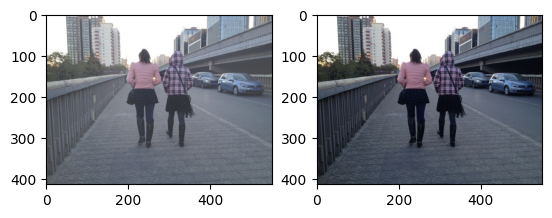

In [4]:
train_data, val_data = data_path(clear_images_folder, haze_folder)

plt.subplot(1, 2, 1)
plt.imshow(Image.open(train_data[10][0]))
plt.subplot(1, 2, 2)  
plt.imshow(Image.open(train_data[10][1]))

**Now we need a function that translate our jpeg file to machine readable data**

In [5]:
def load_image(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.io.decode_jpeg(img, channels = 3) # Decode the image to RGB 3 channels
    img = tf.image.resize(img, size = (256, 256), antialias = True) # Resize all images to a standard 256x256 size
    img = img / 255.0 # Normalize the image magnitude to fit inbetween 0 and 1
    return img

**Lastly, we need a function that loads all translated data and batch them to neural network acceptable data type(BatchDataSet)**

In [6]:
def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(100).batch(batch_size)
    
    return train, val

**Now let us define the batch size, load the data and view the train data that is going to be fed to the model**

In [7]:
batch_size = 1 #A batch size of 1 produces better results as proposed by a research paper done by Isola et al. (2017)
train, val = dataloader(train_data, val_data, batch_size)
train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

<h3>Section 4: Conditional Generative Adversarial Network(cGAN) Modeling</h3>

To understand cGAN, we must first understand GAN

GAN represents an initial training approach. It facilitates a dialogue between two networks: the generator and the discriminator.

On one side, the generator creates fake images that are supposed to be as realistic as possible, with the aim of deceiving the opposing network: the discriminator.

On the other side, the discriminator observes images coming from both the generator and a database. It must determine which images come from the database (and label them as real) and which images are generated by the generator (and are therefore fake).

Each network will receive positive feedback for correctly performing their tasks and negative feedback otherwise.

cGAN allows the process to evolve by considering additional information, such as labels. It is the foundation for image to image translation model that we will be developing later.

Image to image translation, or pix2pix model, as the name suggests, maps an input image to an output image. The process is done by first sample the features of input images using convolution layers to generate context, then reverse the process by calling transposed convolution layers to generate images of appropriate sizes. 

**Let us start by defining a few wrapper functions that add bundles of layers so our model defining won't be as messy**

**Downsample function adds convolutional layer to the sample, normalises (shift the distribution to be centered around 0 with standard deviation of 1) the output on request and adding an activation function to the outputs**

In [30]:
OUTPUT_CHANNELS = 3 # The number of channels in the output image

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02) # Initialize the weights of the convolutional layers with a normal distribution

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  # Normalise the output of the convolutional layer
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  # Apply a Leaky ReLU activation function
  result.add(tf.keras.layers.LeakyReLU())

  return result

**Upsample is a similar function that reverses the sampling process,containing a Transpose conv2D layer to interpolate the input, normalising layer that normalises (shift the distribution to be centered around 0 with standard deviation of 1) the output and applying an activation function to the outputs**

**Let us try another way to prevent overfitting. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged**

**We will add in this layer on request**

In [31]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear'))
  
  result.add(
    tf.keras.layers.Conv2D(filters, size, padding='same',
                           kernel_initializer=initializer, use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

**Now we defined our downsample layers bundle and upsample layers bundle, let us construct a model for our image generator**

**We are trying to sample the inputs as much as we can to extract more information and context**

**Potential information loss are mitigated by saving all the intermediate downsample outputs as skip connection and presenting them to upsampling layers together with the inputs for consideration** 

In [33]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  
  Upsampled = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
  last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1,
                                padding='same', kernel_initializer=initializer,
                                activation=None) # The output image is passed through a tanh activation function to normalize the pixel values between -1 and 1
  

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x) # Record the outputs of each downsampling layer as the skip connections, skip connections are used to provide the upsampling layers with more detailed informations from the input, which helps in the reconstruction of the image

  skips = reversed(skips[:-1]) # Reversing the skip connection order for upsampling

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip]) # Concatenate the output of the upsampling layer with the corresponding skip connection

  x = Upsampled(x)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

**Let us build the model and look at the output**

**Not surprising, untrained model gives us an fully nonsensical output**

1/1 [==============================] - 0s 400ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


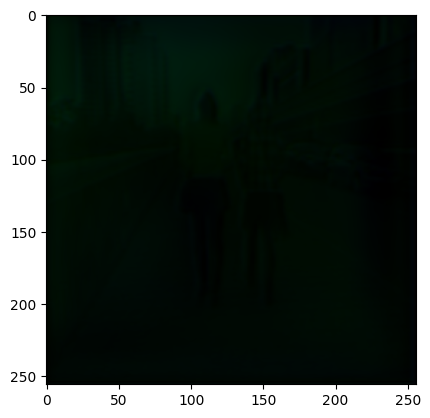

In [34]:
generator = Generator()
gen_output = generator.predict(train.take(1))
plt.imshow(np.squeeze(gen_output))

**Recall that we a GAN model is but a competition between 2 models? Now that we have our generator, let us define our discriminator**

**Discriminator takes in 2 picture inputs, for our case, one input will be the same hazed input that is fed to the generator and the other will be either the ground truth or the generated output**

**The output of the discriminator will be a proability map telling if image is real for every feature cell**

**The differentiation of the discriminator outputs from ground truth and generated output will be used to calculate losses for training**



In [36]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # Define the input shapes
  predicted = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  target = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([predicted, target])  # input is the combination of the 2 pictorial inputs

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[predicted, target], outputs=last)

**Similarly, we call our discriminator function and feed in appropriate data to see a sample output**

In [37]:
discriminator = Discriminator()
for example_input, example_target in train.take(1):
    discriminator_output = discriminator([example_input, generator(example_input)])
    #discriminator_output = discriminator([example_input, example_target])
discriminator_output

<tf.Tensor: shape=(1, 30, 30, 1), dtype=float32, numpy=
array([[[[-1.76161043e-02],
         [-1.05482908e-02],
         [-5.56805916e-03],
         [-1.13234087e-03],
         [-7.04641803e-04],
         [-5.66096511e-04],
         [-8.80183536e-04],
         [-5.97008737e-04],
         [-9.68146836e-04],
         [-1.25847803e-03],
         [-1.24078593e-03],
         [-1.11817219e-03],
         [-5.57535910e-04],
         [-5.51600708e-04],
         [-9.26087610e-04],
         [-3.74668743e-04],
         [-6.07483787e-04],
         [-6.17060228e-04],
         [-1.95948291e-04],
         [-5.65322815e-04],
         [-2.07794365e-04],
         [-2.98667233e-04],
         [ 1.69830164e-04],
         [ 3.00766784e-04],
         [ 9.06575704e-04],
         [ 1.12604792e-03],
         [ 6.69475645e-04],
         [ 1.36056484e-03],
         [ 9.68074705e-03],
         [ 2.69572269e-02]],

        [[-3.50292921e-02],
         [-3.14873233e-02],
         [-2.44437270e-02],
         [-2.30553

**It is time to customise our training function**

**For both generator and discriminator, we need a seperate loss function to facillitate their training**

**For generator, the loss founction considers mainly how well the generated image is able to trick the discriminator, and the difference between generated image and actual ground truth**

In [38]:
LAMBDA = 100 # A constant used to adjeust the weight of the L1 loss in the generator loss function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Binary cross entropy is used to calculate the loss of the discriminator

def generator_loss(disc_generated_output, gen_output, target):
  # We make a matrix of identical shape to the discriminator output and fill it with ones,
  # Since the generator is trying to generate images that are as close to the target as possible, the ideal output of the discriminator should be 1
  # We then compare the output of the discriminator with the ideal output and calculate the loss using binary cross entropy
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output) 

  # Mean absolute error is used to compare the generated image with the target image
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # The generator loss is the sum of the gan loss and the L1 loss multiplied by a constant LAMBDA
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**For discriminator loss, the function mainly considers how well discriminator can identify ground truth as real and generated as fake**

In [39]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # We make a matrix of identical shape to the discriminator output and fill it with ones,
  # Since the discriminator is trying to distinguish between real and fake images, the ideal output of the discriminator for real images should be 1
  # We then compare the output of the discriminator with the ideal output and calculate the loss using binary cross entropy
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) 

  # Similarly, we make a matrix of identical shape to the discriminator output and fill it with zeros,
  # Since the discriminator is trying to distinguish between real and fake images, the ideal output of the discriminator for fake images should be 0
  # We then compare the output of the discriminator with the ideal output and calculate the loss using binary cross entropy
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss # The discriminator loss is the sum of the real loss and the generated loss

  return total_disc_loss

**Now we define our gradient descent method**

**Similarly, generator and discriminator needs seperate methods**

In [40]:
generator_optimizer = keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

**We define our directories to save our training checkpoints**

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**To visualise the training more clearly, let us define a functon that display the hazy iamge, ground truth and generated image side by side**

In [42]:
import skimage as ski
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.axis('off')
    
    orig_img_np = orig_img[0].numpy()
    dehazed_img_np = dehazed_img[0].numpy()
    PSNR = ski.metrics.peak_signal_noise_ratio(orig_img_np, dehazed_img_np, data_range = 1)
    print('PSNR: ', PSNR)
    plt.show()
    return PSNR
    

**We can try out our function by taking the training data pass in our generator**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  3.677344436958623


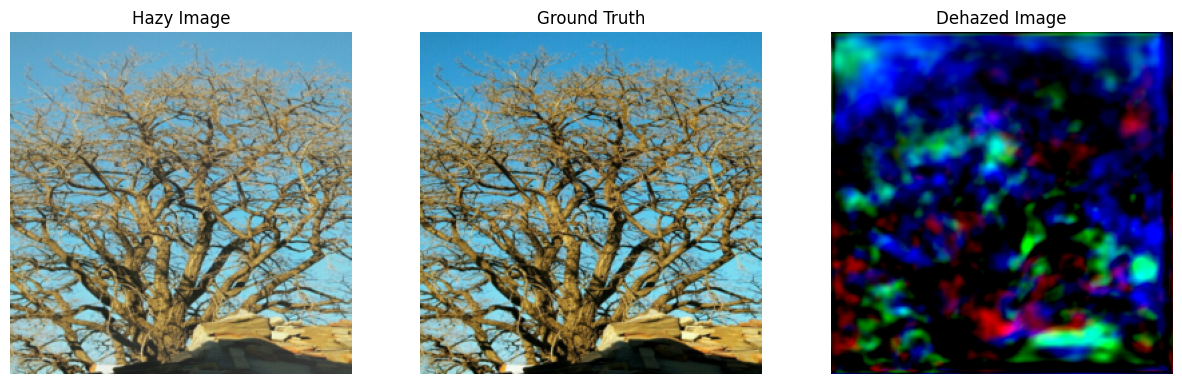

In [43]:
for example_input, example_target in train.take(1):
  display_img(generator, example_input, example_target)

**We will also be using tensorboard to visualise our training process**

**Thus we need to specify a directory as well as set up a summary writer to generate event files during training**

In [44]:
log_dir="logs/" # Directory to store the logs

# Create a summary writer
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # Create a summary writer to log the loss and accuracy of the model

**To the most important step of our custom fit function, we need a function that compiles all our previous functions and train our models**

**The function needs to:**
1. call the generator and discriminator to produce output 
2. collate the losses of generator and discriminator
3. Apply gradient descent in search for a solution
4. Update the trainable weights in generator and discriminator

In [45]:
@tf.function  # The tf.function decorator compiles the function into a callable TensorFlow graph

def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # Use gradient tape to record the operations for automatic differentiation
    
    # Calling generator and discriminator functions to produce the output
    gen_output = generator(input_image, training=True)
    gen_output = tf.clip_by_value(gen_output, 0, 1) # Clip the pixel values to be between 0 and 1
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Calculate the loss of the generator and discriminator using the generated output and the target
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Calculate the gradients of the generator and discriminator loss with respect to the trainable variables
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  # Apply the gradients to the optimiser to update the weights of the generator and discriminator
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  # Log the loss and accuracy of the model
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss
  
  

**Finally, we define a fit function that iterates through the dataset, calls training function and displays the necessary information**

In [46]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()
  history = {'gen_total_loss': [], 'gen_gan_loss': [], 'gen_l1_loss': [], 'disc_loss': [], "PSNR" : []}

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, step)
    
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()
      print(f"Printing image for step: {step}")
      PSNR = display_img(generator, input_image, target)
      print(f"Step: {step}")
      print(f" Generator Total Loss: {gen_total_loss}")
      print(f" Discriminator Loss: {disc_loss}")
      history['gen_total_loss'].append(gen_total_loss)
      history['gen_gan_loss'].append(gen_gan_loss)
      history['gen_l1_loss'].append(gen_l1_loss)
      history['disc_loss'].append(disc_loss)
      history['PSNR'].append(PSNR)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      
  return history

<h3>Section 5: Training and Validation</h3>

**Let us fit the function for a number of episodes and see the outcome**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for 1000 steps: 481.18 sec

Printing image for step: 10000
PSNR:  28.31431986155208


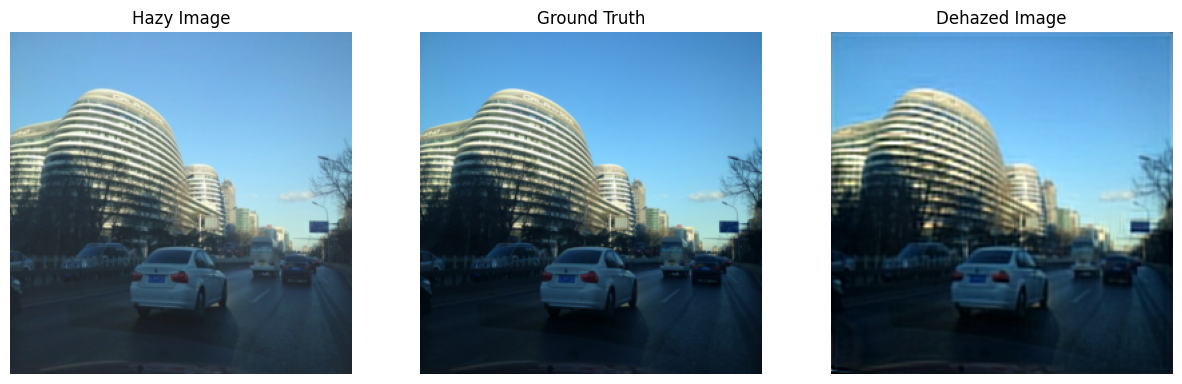

Step: 10000
 Generator Total Loss: 5.967864036560059
 Discriminator Loss: 0.38317638635635376


In [48]:
history = fit(train, val, steps=10001)

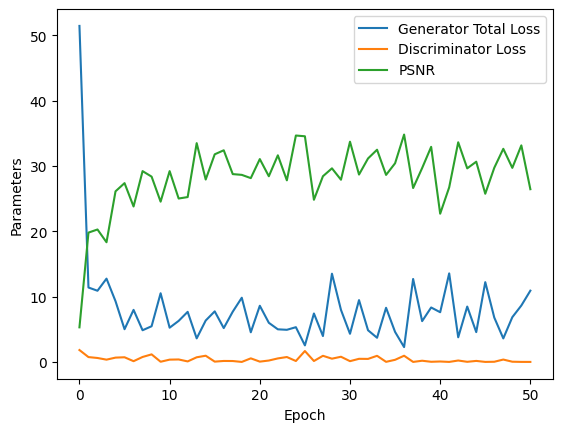

In [26]:
import matplotlib.pyplot as plt

gen_total_loss = history['gen_total_loss']
discriminator_loss = history['disc_loss']

plt.plot(gen_total_loss, label='Generator Total Loss')
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(history['PSNR'], label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('Parameters')
plt.legend()
plt.show()


**We can restore our latest checkpoints and continue from where we left off**

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**We can see that the model is more or less decent in dehazing our dataset**

**Let us call the model on validation set and see the performance**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  31.060425361913275


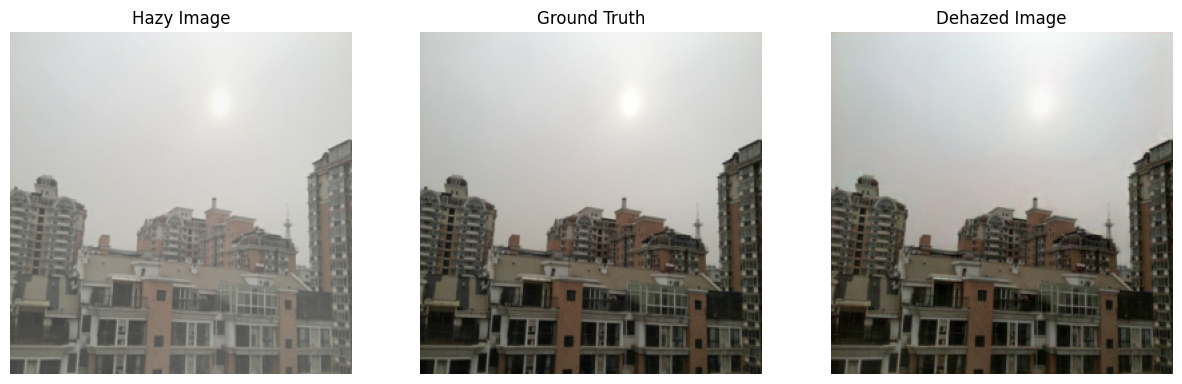

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  31.395982688614428


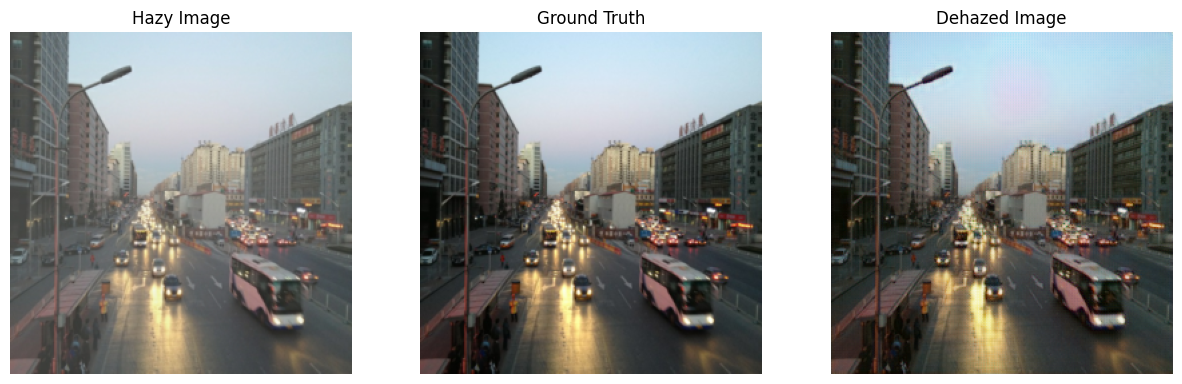

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  30.64301674773207


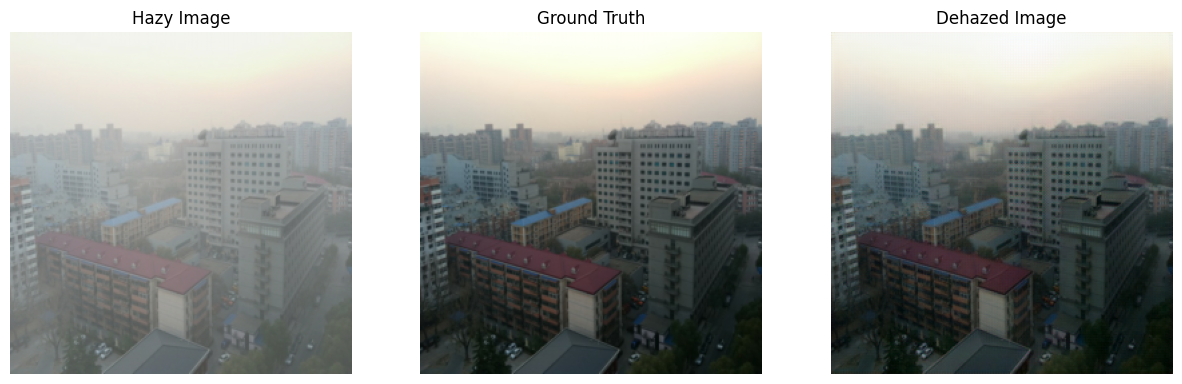

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  25.657562544112796


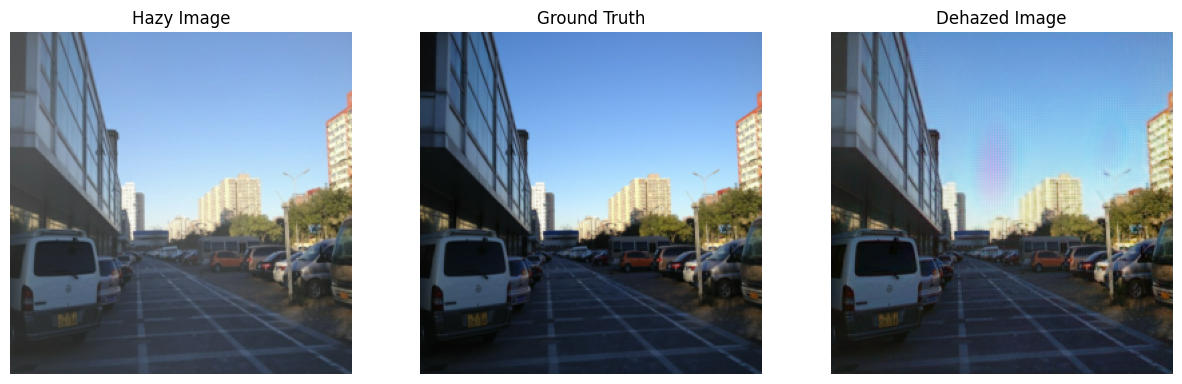

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  27.56077784215766


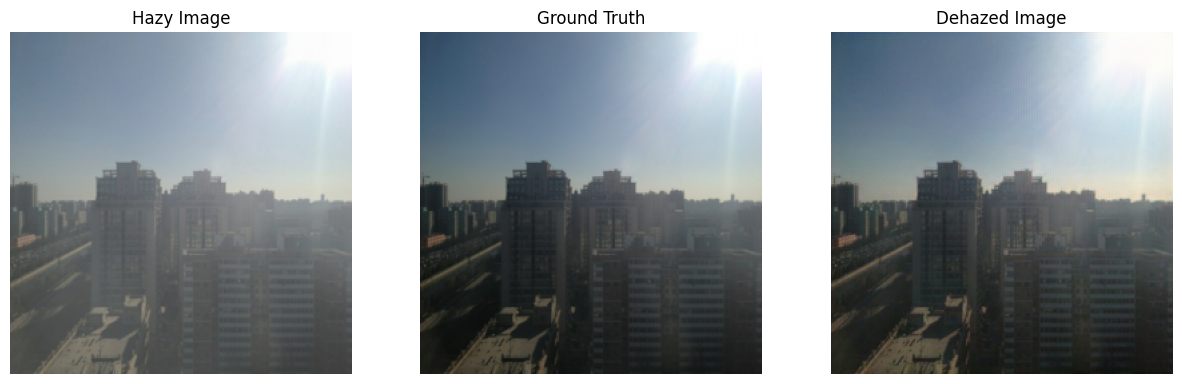

In [22]:
for hazy_img, ground_truth in val.take(5):
  display_img(generator, hazy_img, ground_truth)

<h3>Section 6: Deployment</h3>

**As mentioned image dehazing model is often used as a preprocessing model aim to better the performance of models tasked with more complexed image processing tasks**

**We will have the chance to incoporate our model into the future projects that we will be doing**

**For now, let us test our model on example photos that we pull from the net**

**Example1 is a photo found on a news report about hazy weather (http://www.xinhuanet.com/english/2019-09/13/c_138387707.htm)**

**Apply the same preprocessing techniques and modify the img to an acceptable shape**

In [28]:
img = tf.io.read_file('example1.jpg')
img = tf.io.decode_jpeg(img, channels = 3) 
img = tf.image.resize(img, size = (256, 256), antialias = True)  
img = img / 255.0

**let us plot the image to see the before and after**

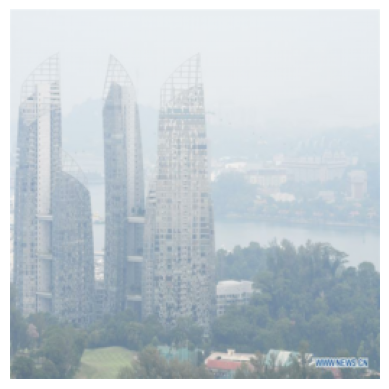

In [29]:
plt.imshow(img)
plt.axis('off')
plt.show()

**Pass the img into the generator and check the result**

**We can see that some pixel qualities are lost through processing but the colours are much more vibrant**

1/1 [==============================] - 0s 212ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


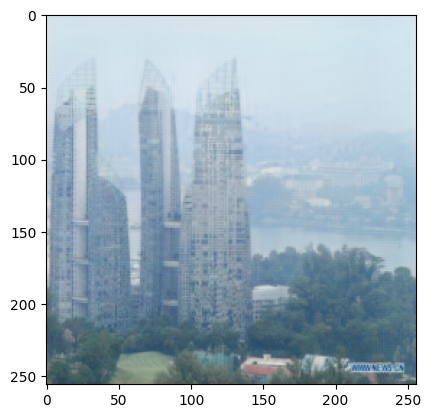

In [30]:
output = generator.predict(tf.expand_dims(img, 0))
plt.imshow(np.squeeze(output))